In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [3]:
dataset = Path('datasets/sfm_South-Building/')
images = dataset / 'South-Building/images/'

outputs = Path('outputs/sfm/')
sfm_pairs = outputs / 'pairs-exhaustive.txt'  # exhaustive matching
sfm_dir = outputs / 'sfm_superpoint+superglue'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

features = feature_conf['output']
feature_file = f"{features}.h5"
match_file = f"{features}_{matcher_conf['output']}_{sfm_pairs.stem}.h5"

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data, and refined with SfM.

In [3]:
%%bash -s "$dataset"
wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1
unzip datasets/sfm_South-Building/South-Building.zip -d $1

--2020-09-09 10:08:21--  http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip
Resolving cvg.ethz.ch (cvg.ethz.ch)... 129.132.85.27
Connecting to cvg.ethz.ch (cvg.ethz.ch)|129.132.85.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230948942 (220M) [application/zip]
Saving to: ‘datasets/sfm_South-Building/South-Building.zip’

     0K .......... .......... .......... .......... ..........  0%  270K 13m55s
    50K .......... .......... .......... .......... ..........  0%  539K 10m26s
   100K .......... .......... .......... .......... ..........  0%  539K 9m17s
   150K .......... .......... .......... .......... ..........  0%  542K 8m42s
   200K .......... .......... .......... .......... ..........  0%  541K 8m20s
   250K .......... .......... .......... .......... ..........  0% 79.5M 6m57s
   300K .......... .......... .......... .......... ..........  0%  545K 6m57s
   350K .......... .......... .......... .......... ..........  0% 49.4M

CalledProcessError: Command 'b'wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1\nunzip datasets/South-Building.zip -d $1\n'' returned non-zero exit status 9.

## Extract local features

In [5]:
extract_features.main(feature_conf, images, outputs)

[09/09/2020 10:58:52 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
Loaded SuperPoint model
[09/09/2020 10:58:52 INFO] Found 128 images in root datasets/sfm_South-Building/South-Building/images.


  0%|          | 0/128 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
100%|██████████| 128/128 [01:58<00:00,  1.08it/s]

[09/09/2020 11:00:50 INFO] Finished exporting features.


## Exhaustive matching
Since the dataset is small, we can match all $\frac{n(n-1)}{2}$ images pairs. To do so, we pass the argument `exhaustive=True` and make sure that the pair file does not exist yet. If your dataset is larger, exhaustive matching might take a long time - consider selecting fewer pairs using image retrieval and `hloc/pairs_from_retrieval.py`.

In [4]:
match_features.main(matcher_conf, sfm_pairs, features, outputs, exhaustive=True)

[09/09/2020 12:11:01 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[09/09/2020 12:11:01 INFO] Writing exhaustive match pairs to outputs/sfm/pairs-exhaustive.txt.
cuda
Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 8128/8128 [35:50<00:00,  3.78it/s]

[09/09/2020 12:46:56 INFO] Finished exporting matches.


## SfM reconstruction
Run COLMAP on the features and matches.

In [ ]:
reconstruction.main(
    sfm_dir,
    images,
    sfm_pairs,
    outputs / feature_file,
    outputs / match_file)

[09/09/2020 12:46:56 INFO] Creating an empty database...
[09/09/2020 12:46:56 INFO] Importing images into the database...
[09/09/2020 12:47:03 INFO] Importing features into the database...


100%|██████████| 128/128 [00:00<00:00, 2908.12it/s]

[09/09/2020 12:47:04 INFO] Importing matches into the database...



100%|██████████| 8128/8128 [00:02<00:00, 3099.41it/s]


[09/09/2020 12:47:06 INFO] Performing geometric verification of the matches...
[09/09/2020 12:48:01 INFO] Running the 3D reconstruction...
[09/09/2020 12:48:01 INFO] colmap mapper --database_path outputs/sfm/sfm_superpoint+superglue/database.db --image_path datasets/sfm_South-Building/South-Building/images --output_path outputs/sfm/sfm_superpoint+superglue/models --Mapper.num_threads 16


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

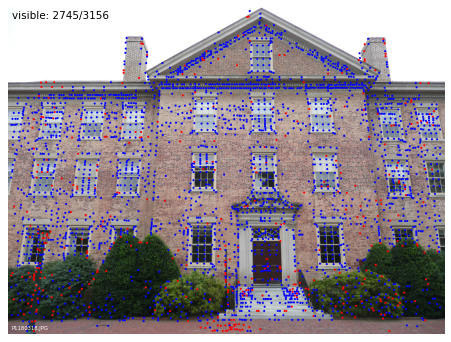

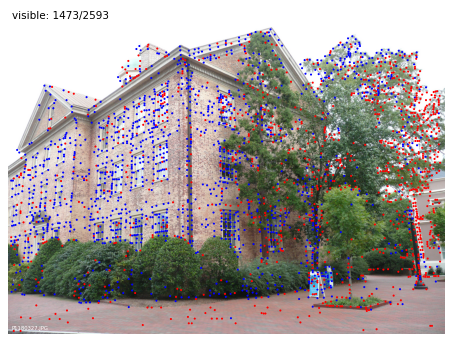

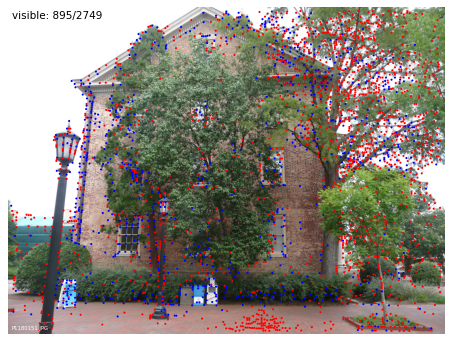

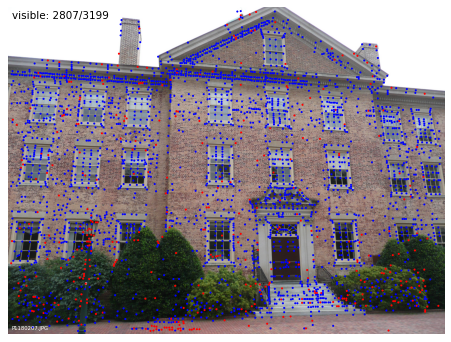

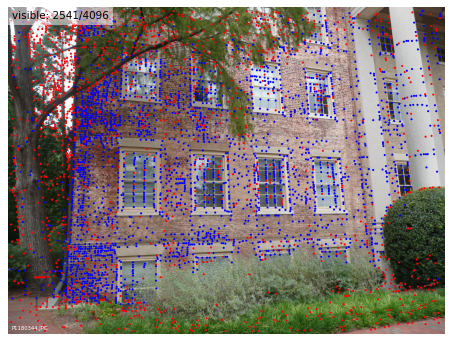

In [4]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='visibility', n=5)

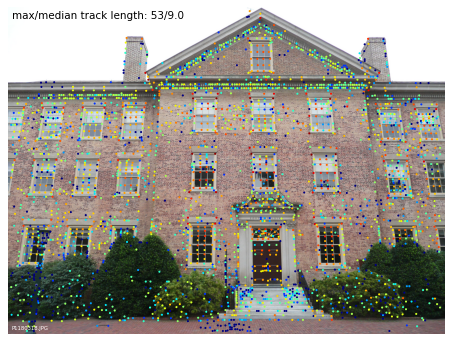

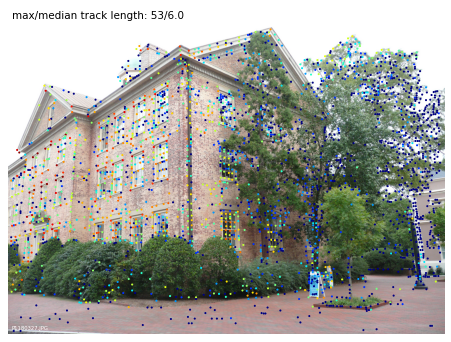

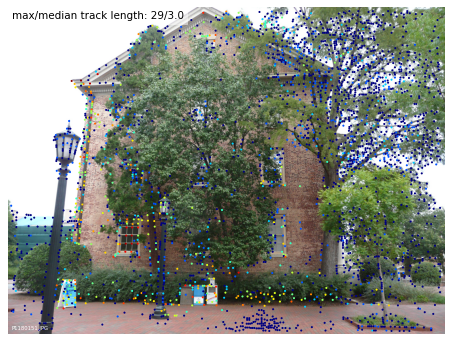

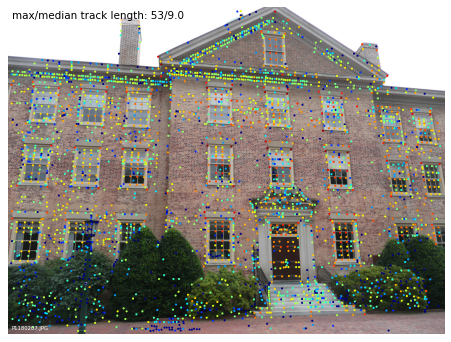

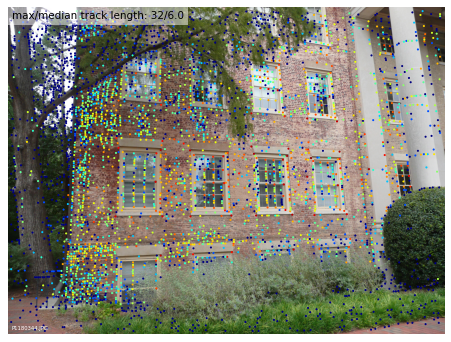

In [5]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='track_length', n=5)

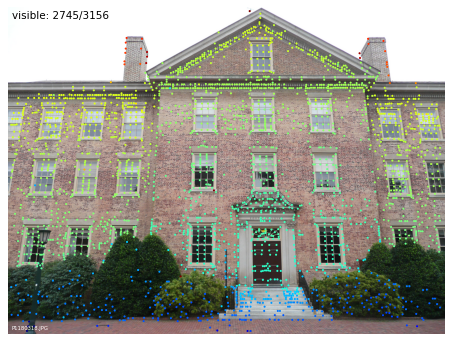

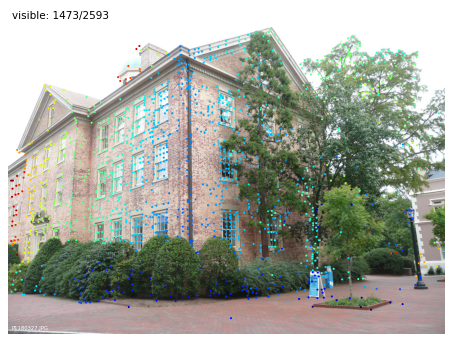

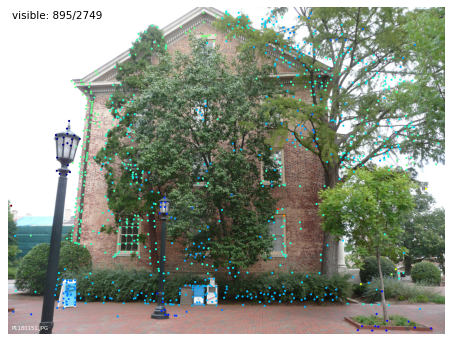

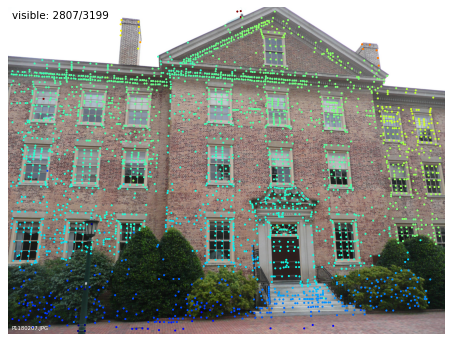

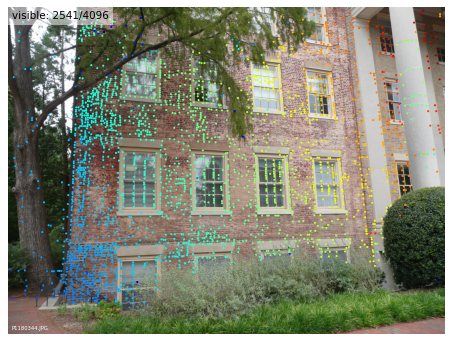

In [6]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='depth', n=5)